## Data Distribution

In [12]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from CNN.utility import train_routine

SPLIT_PERC = {'train': 0.8, 'val': 0.2}
DATA_DIR = os.path.join('data', 'mammals_calls')
TO_TRAIN = False
h = 164
w = 397

seed = 2025
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [13]:
subfolders = [f.path for f in os.scandir(DATA_DIR) if f.is_dir()]
data_info = {}
for subfolder in subfolders:
    species_name = os.path.basename(subfolder)
    file_count = len([f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))])
    data_info[species_name] = file_count
count_df = pd.DataFrame(list(data_info.items()), columns=['species', 'file_count'])
count_df = count_df.sort_values(by='file_count', ascending=False)


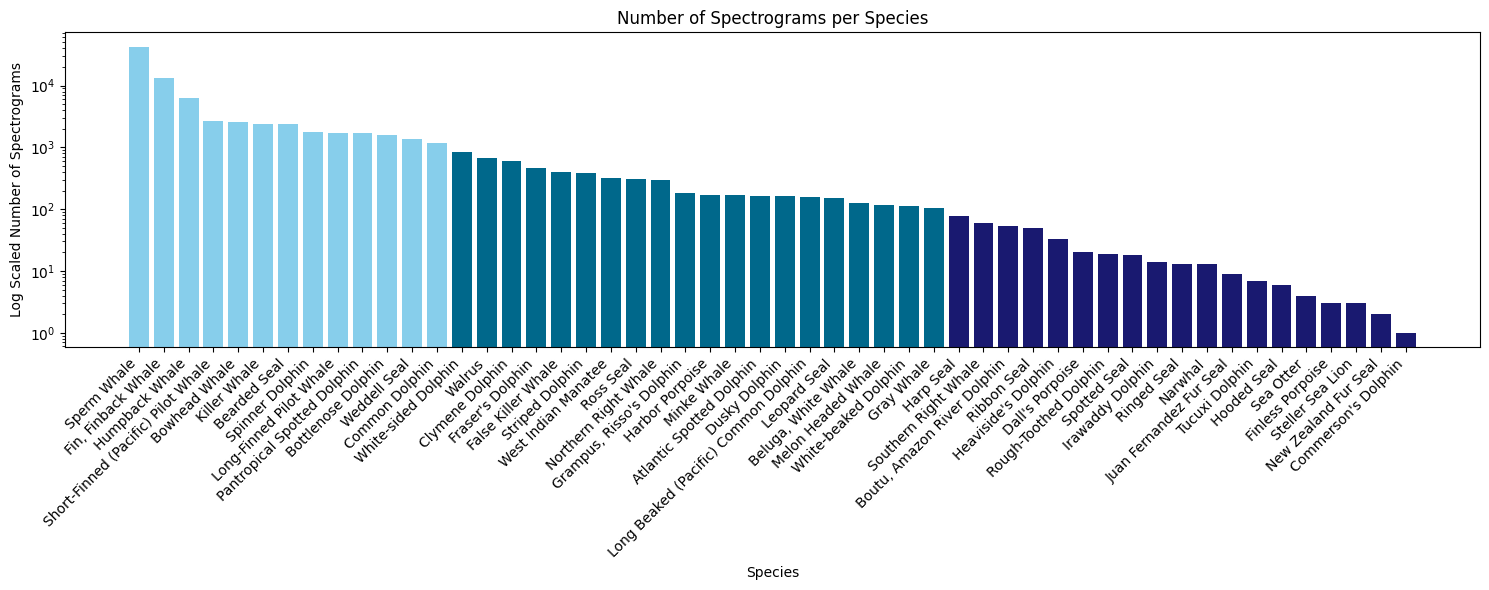

Total number of species: 52
Number of species with more than 1000 spectrograms: 13
Number of species with more than 100 but less than 1000 spectrograms: 20
Number of species with less than 100 spectrograms: 19


In [14]:
count_thousands = count_df[count_df['file_count'] > 1000]
count_hundreds = count_df[(count_df['file_count'] > 100) & (count_df['file_count'] < 1000)]
count_tens = count_df[count_df['file_count'] < 100]

plt.figure(figsize=(15, 6))
plt.bar(count_thousands['species'], count_thousands['file_count'], color="#87CEEB")
plt.bar(count_hundreds['species'], count_hundreds['file_count'], color='#00688B')
plt.bar(count_tens['species'], count_tens['file_count'], color="#191970")
plt.xlabel('Species')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Log Scaled Number of Spectrograms')
plt.yscale("log")
plt.title('Number of Spectrograms per Species')

plt.tight_layout()
plt.show()

print(f'Total number of species: {count_df.shape[0]}')
print(f'Number of species with more than 1000 spectrograms: {count_thousands.shape[0]}')
print(f'Number of species with more than 100 but less than 1000 spectrograms: {count_hundreds.shape[0]}')
print(f'Number of species with less than 100 spectrograms: {count_tens.shape[0]}')


## Training CNN

In [15]:
CNN_CACHE_DIR = os.path.join("data_cache", "CNN")
MODELS_METRICS_DIR = os.path.join("models_metrics")
PATIENCE = 3
if not os.path.exists(MODELS_METRICS_DIR):
    os.makedirs(MODELS_METRICS_DIR)

split_perc = {'train': 0.8, 'val': 0.2}

Training della CNN classica con le classi che contengono più di 1000 sample.

In [16]:

n_classes_1000 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (0, 0), to_train=TO_TRAIN, cardinality=999)

Total classes found: 13


Si ripete il training aggiungendo 10 classi per volta in ordine decrescente in numero di sample contenuti.

In [17]:
#Fino a classe 23
n_classes_plus_10 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_1000, 10), to_train=TO_TRAIN)

Added classes: ['White-sided Dolphin', 'Walrus', 'Clymene Dolphin', "Fraser's Dolphin", 'False Killer Whale', 'Striped Dolphin', 'West Indian Manatee', 'Ross Seal', 'Northern Right Whale', "Grampus, Risso's Dolphin"]
Total classes found: 23


In [18]:
#Fino a classe 33
n_classes_plus_20 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_plus_10, 10), to_train=TO_TRAIN)

Added classes: ['Harbor Porpoise', 'Minke Whale', 'Atlantic Spotted Dolphin', 'Dusky Dolphin', 'Long Beaked (Pacific) Common Dolphin', 'Leopard Seal', 'Beluga, White Whale', 'Melon Headed Whale', 'White-beaked Dolphin', 'Gray Whale']
Total classes found: 33


In [19]:
#Fino a classe 43
n_classes_plus_30 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_plus_20, 10), to_train=TO_TRAIN)

Added classes: ['Harp Seal', 'Southern Right Whale', 'Boutu, Amazon River Dolphin', 'Ribbon Seal', "Heaviside's Dolphin", "Dall's Porpoise", 'Rough-Toothed Dolphin', 'Spotted Seal', 'Irawaddy Dolphin', 'Ringed Seal']
Total classes found: 43


In [20]:
#Fino all'ultima classe
n_classes_plus_rem = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_plus_30, 10), to_train=TO_TRAIN)

Added classes: ['Narwhal', 'Juan Fernandez Fur Seal', 'Tucuxi Dolphin', 'Hooded Seal', 'Sea Otter', 'Finless Porpoise', 'Steller Sea Lion', 'New Zealand Fur Seal']
Total classes found: 51


## Output Plots

In [104]:
def get_class_metrics(row, all_classes_df, metrics_list):
    for metric in metrics_list:
        class_num = row['index']
        col_name = rf'{class_num}_{metric}'
        class_metrics = all_classes_df[col_name]
        row[metric] = class_metrics
    return row

def process_metrics(n_classes, training_date):
    all_classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, f'{training_date}_training', f'{n_classes}_CNN_metrics.csv'))
    all_classes_df = all_classes_df.loc[:, all_classes_df.columns.str.match(r'^\d')]
    last_epoch_metrics = all_classes_df.iloc[-1]

    classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, f'{training_date}_training', f'{n_classes}_label_to_index.csv'))

    metrics_list = ['precision', 'recall', 'f1-score', 'support']
    classes_df = classes_df.apply(get_class_metrics, axis=1, all_classes_df=last_epoch_metrics, metrics_list=metrics_list)
    classes_df['label'] = classes_df['label'].apply(lambda x: ' '.join(x.split(' ')[:2]) if len(x) > 20 else x)
    classes_df.to_csv(os.path.join(MODELS_METRICS_DIR, f'{training_date}_merged_metrics', f'{n_classes}_merged_metrics.csv'), index=False)

def metrics_plot_builder(metrics_df):
    metrics_list = ['precision', 'recall', 'f1-score']
    f = 1
    fig = plt.figure(figsize=(15, 15))
    for metric in metrics_list:
        axs = plt.subplot(2, 2, f)
        axs.bar(metrics_df['label'], metrics_df[metric], color="#87CEEB")
        for i, (metric_value, support) in enumerate(zip(metrics_df[metric], metrics_df['support'])):
            label_pos = metric_value - (metric_value/2) if metric_value > 0 else metric_value + 0.02
            plt.text(i, label_pos, f'n:{int(support)}', ha='center', va='bottom', fontsize=9, rotation=90)
        axs.set_xlabel('Class')
        axs.tick_params(axis='x', rotation=90)
        axs.set_ylabel(metric.capitalize())
        axs.set_title(f'{metric.capitalize()} per Class (ordered by Support - descending)')
        
        f += 1
    fig.tight_layout()
    return fig

In [105]:
curr_training_date = '01-09'
process_metrics(n_classes_1000, curr_training_date)
process_metrics(n_classes_plus_10, curr_training_date)
process_metrics(n_classes_plus_20, curr_training_date)
process_metrics(n_classes_plus_30, curr_training_date)
process_metrics(n_classes_plus_rem, curr_training_date)

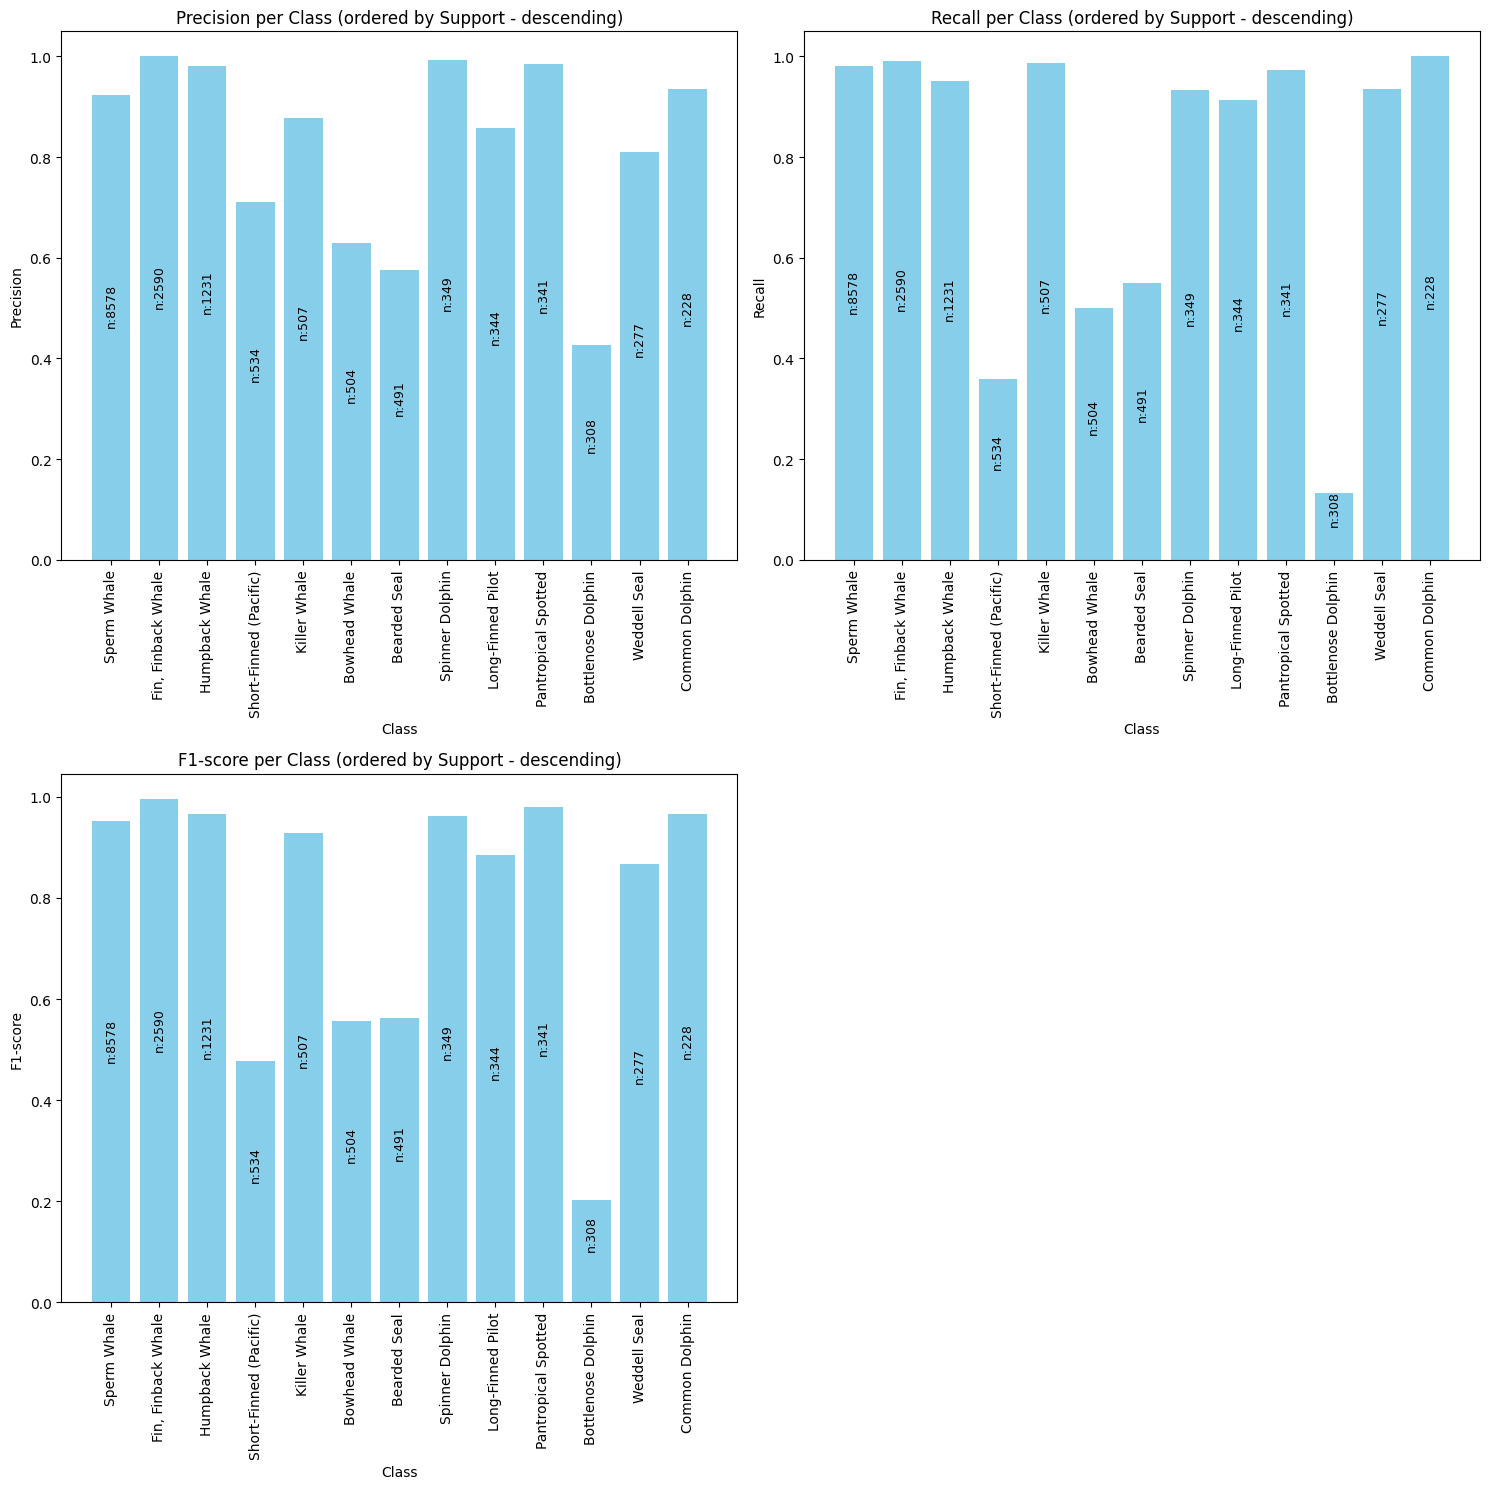

In [106]:
curr_metrics_date = '01-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_1000}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()

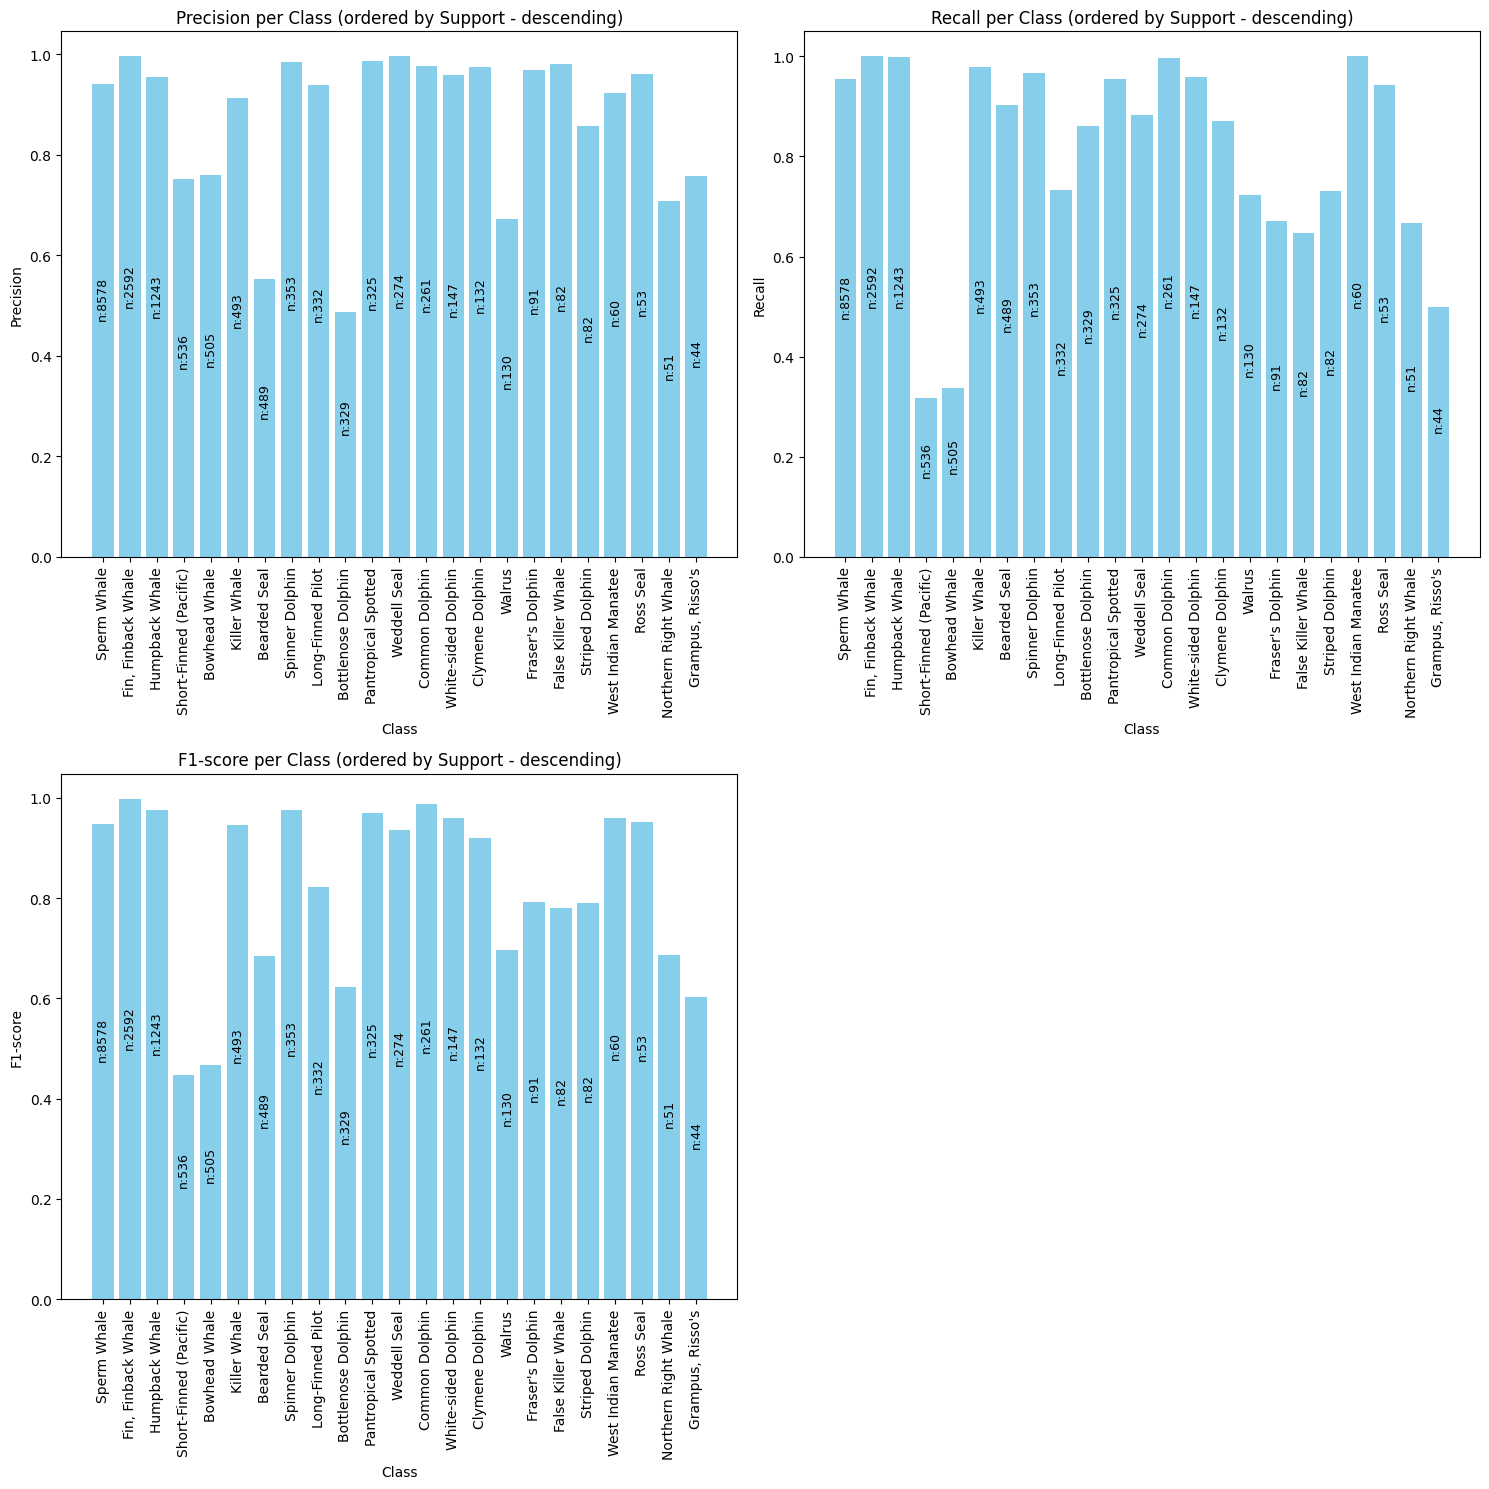

In [107]:
curr_metrics_date = '01-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_plus_10}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()

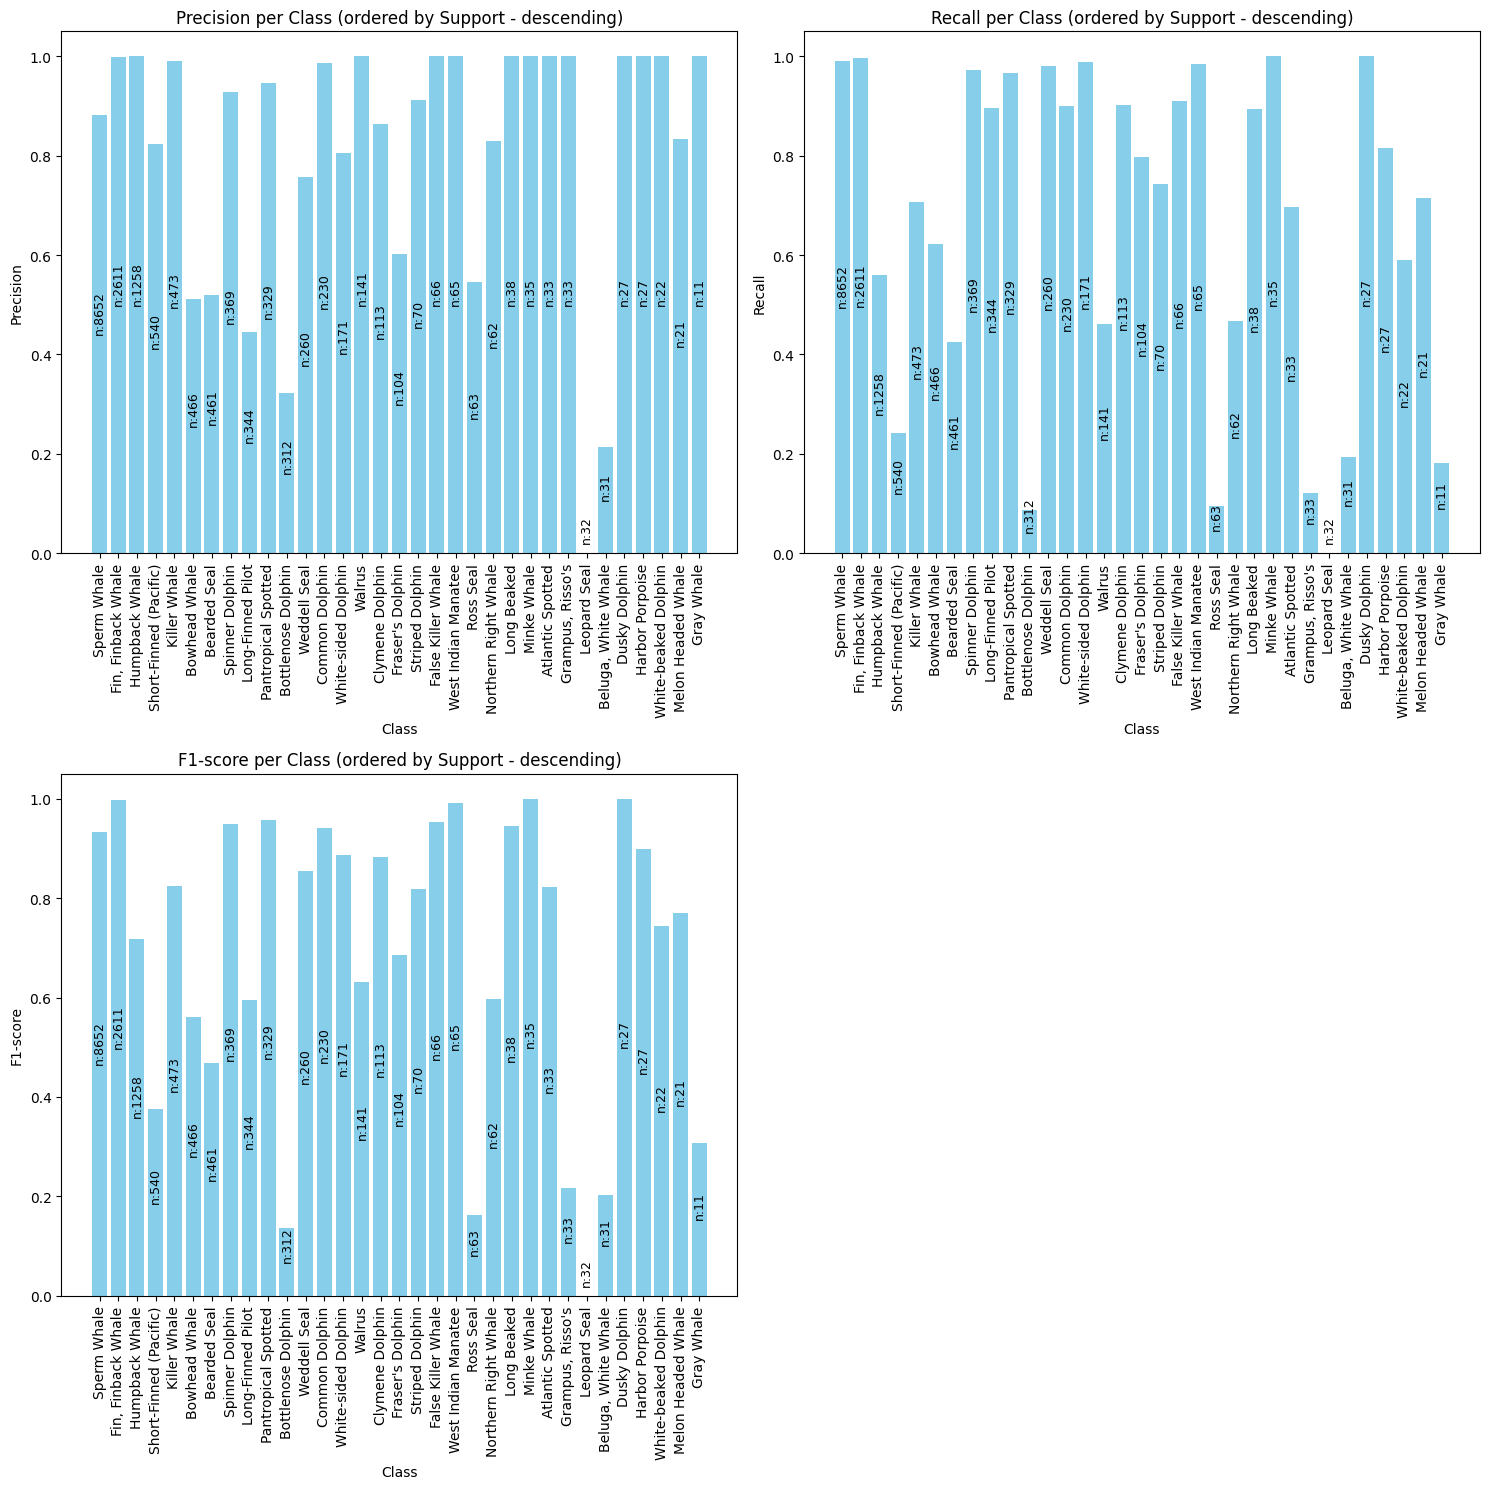

In [108]:
curr_metrics_date = '01-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_plus_20}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()

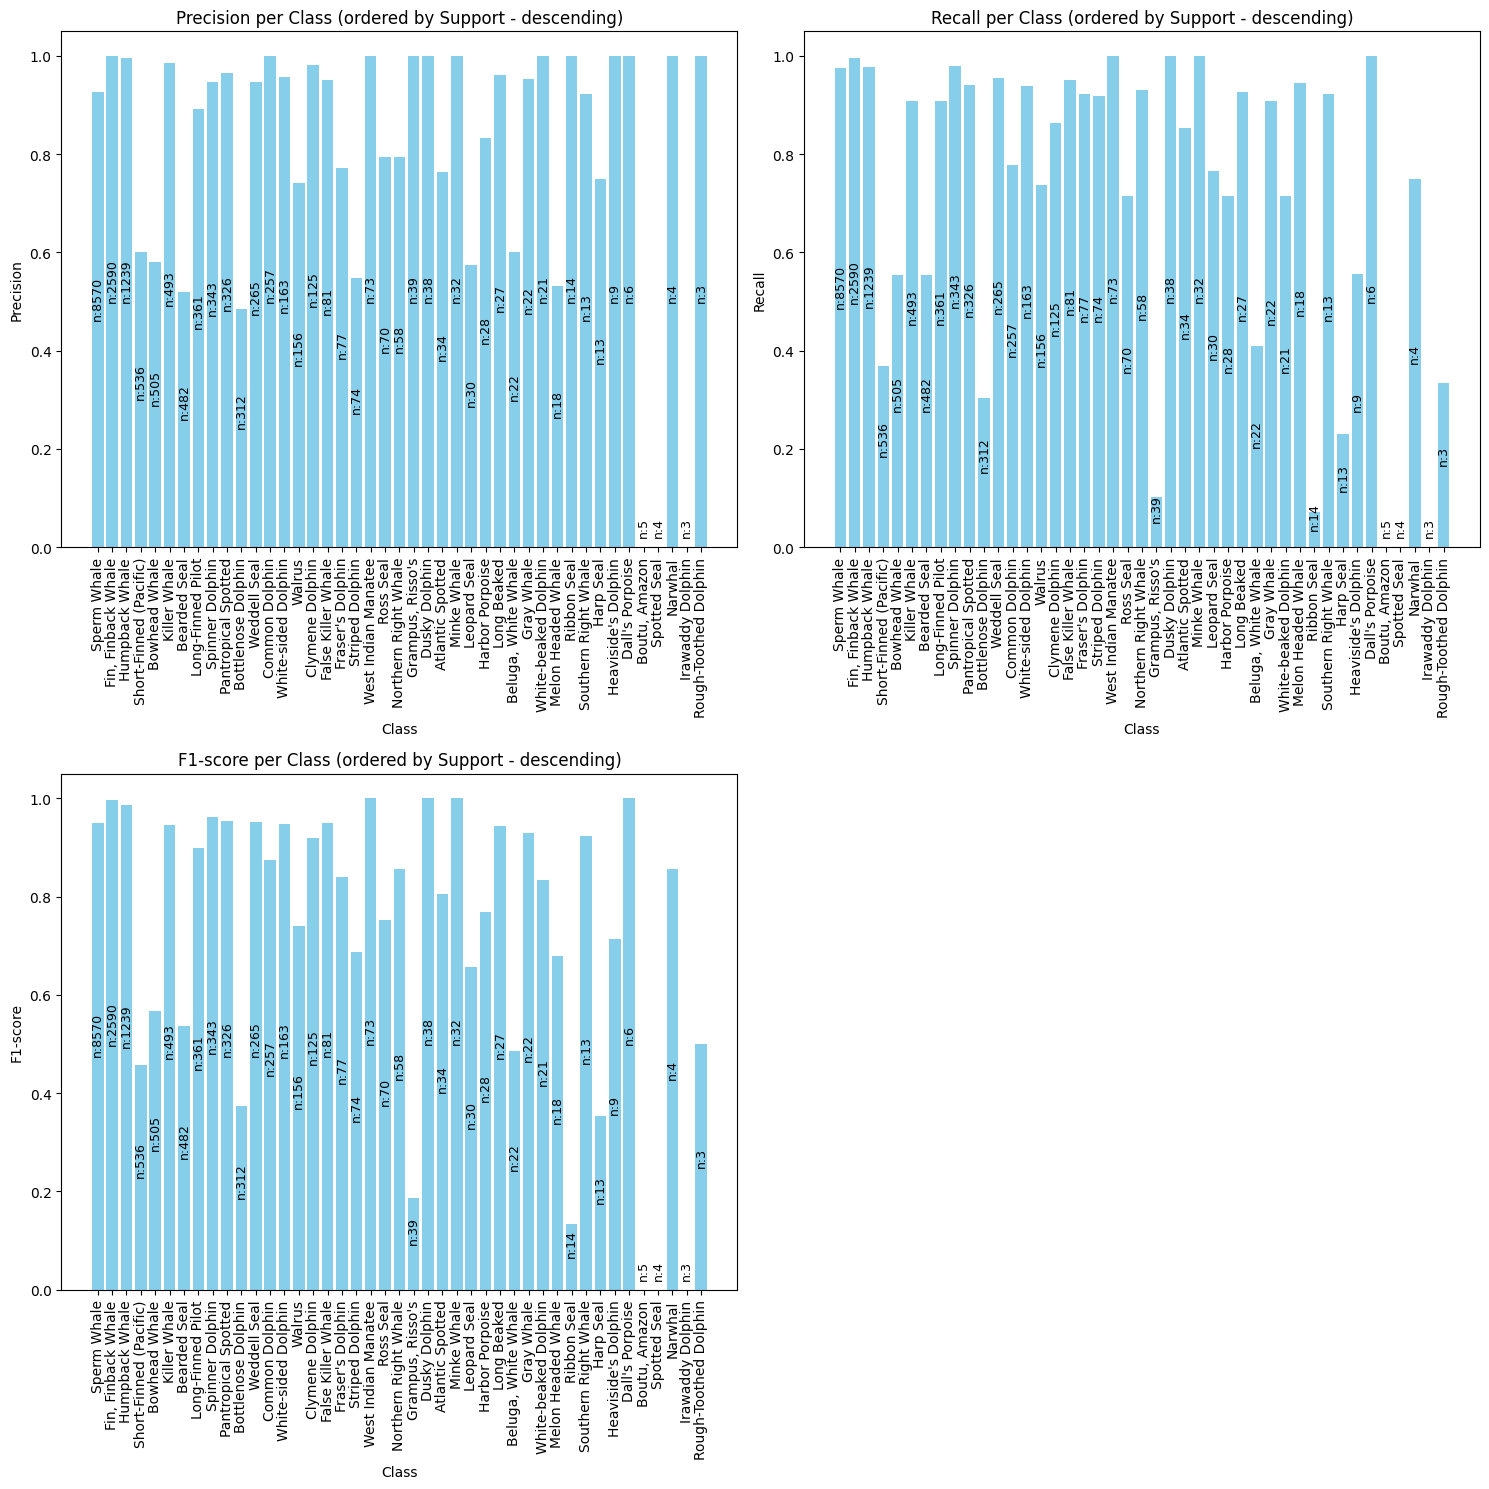

In [109]:
curr_metrics_date = '01-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_plus_30}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()

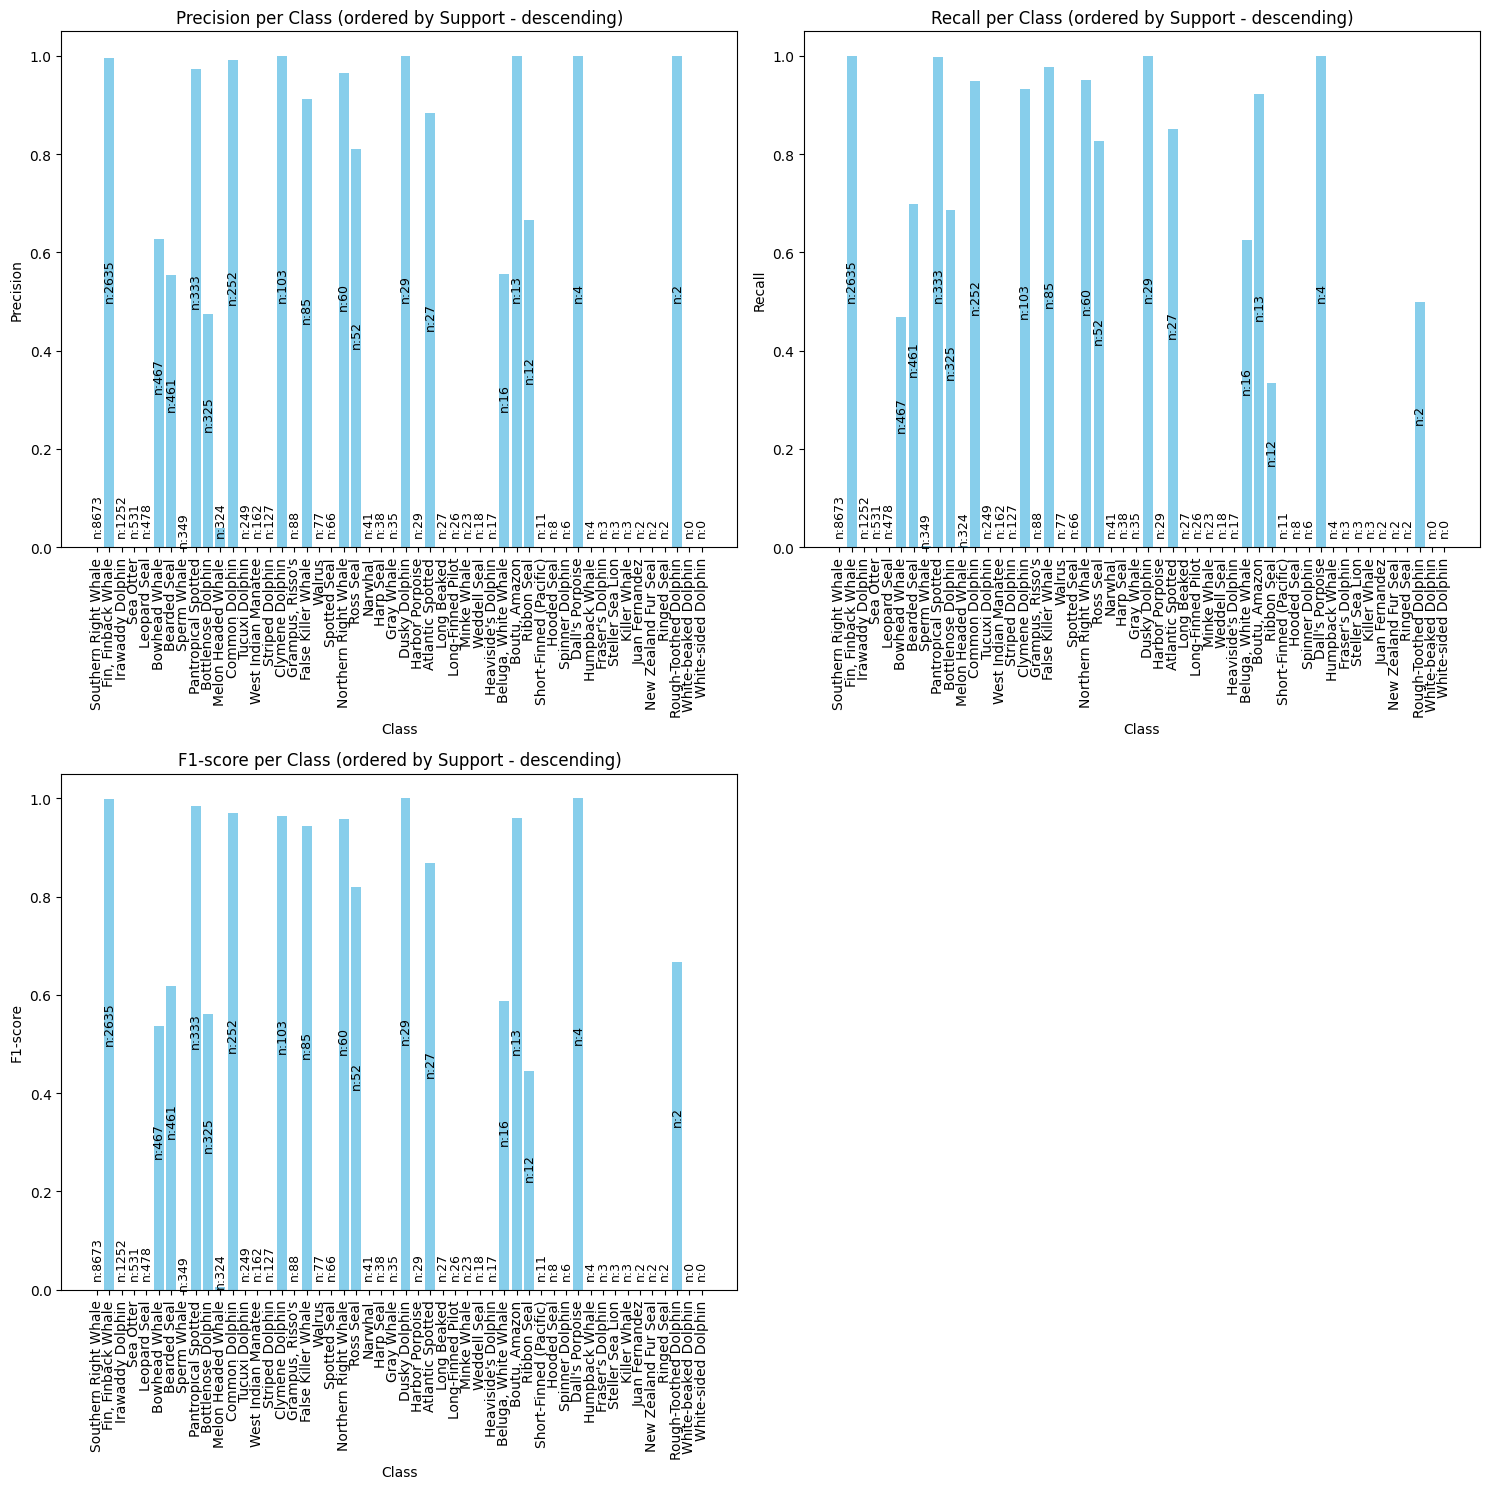

In [110]:
curr_metrics_date = '01-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_plus_rem}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()